# 1. 라이브러리

In [49]:
import pandas as pd
import numpy as np
import os
import re
import psycopg2
import psycopg2.extras

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc
from wordcloud import WordCloud

In [72]:
# 나눔고딕 폰트 경로
FONT_PATH = "/home/kse/anaconda3/envs/chzzk/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic.ttf"

# 1. 폰트 직접 등록
font_manager.fontManager.addfont(FONT_PATH)

# 2. 등록된 폰트 이름 가져오기
nanum_font = font_manager.FontProperties(fname=FONT_PATH)
print("폰트 이름:", nanum_font.get_name())

# 3. 전역 설정
rcParams["font.family"] = nanum_font.get_name()

폰트 이름: NanumGothic


In [69]:
nanum_font.get_name()

'NanumGothic'

# 2. DB 연결

In [3]:
conn = psycopg2.connect(
    host="xx.xx.xx.xx",
    port="5432",
    dbname="postgres",
    user="postgres",
    password="password"
)
cur = conn.cursor()

# 3. 데이터 정제

## 3.1. 데이터 가져오기

In [4]:
batch_size = 10000
last_id = 0
dfs = []

while True:
    query = """
        SELECT id, streamer_id, user_id, msg, ts
        FROM chat_logs
        WHERE id > %s
        ORDER BY id ASC
        LIMIT %s;
    """
    cur.execute(query, (last_id, batch_size))
    rows = cur.fetchall()
    
    if not rows:
        break
    
    df = pd.DataFrame(rows, columns=["id", "streamer_id", "user_id", "msg", "ts"])
    dfs.append(df)
    
    last_id = rows[-1][0]   # 마지막 row의 id를 다음 루프 시작점으로
    print(f"{last_id} 까지 읽음 ({len(rows)} rows)")

10201 까지 읽음 (10000 rows)
20202 까지 읽음 (10000 rows)
30202 까지 읽음 (10000 rows)
40206 까지 읽음 (10000 rows)
50206 까지 읽음 (10000 rows)
60207 까지 읽음 (10000 rows)
70207 까지 읽음 (10000 rows)
80207 까지 읽음 (10000 rows)
90207 까지 읽음 (10000 rows)
100207 까지 읽음 (10000 rows)
110207 까지 읽음 (10000 rows)
120207 까지 읽음 (10000 rows)
130207 까지 읽음 (10000 rows)
140207 까지 읽음 (10000 rows)
150207 까지 읽음 (10000 rows)
160207 까지 읽음 (10000 rows)
170207 까지 읽음 (10000 rows)
180207 까지 읽음 (10000 rows)
190207 까지 읽음 (10000 rows)
200208 까지 읽음 (10000 rows)
210209 까지 읽음 (10000 rows)
220279 까지 읽음 (10000 rows)
230279 까지 읽음 (10000 rows)
240279 까지 읽음 (10000 rows)
250282 까지 읽음 (10000 rows)
260282 까지 읽음 (10000 rows)
270282 까지 읽음 (10000 rows)
280282 까지 읽음 (10000 rows)
290282 까지 읽음 (10000 rows)
300282 까지 읽음 (10000 rows)
310282 까지 읽음 (10000 rows)
320282 까지 읽음 (10000 rows)
330282 까지 읽음 (10000 rows)
340282 까지 읽음 (10000 rows)
350282 까지 읽음 (10000 rows)
360282 까지 읽음 (10000 rows)
370282 까지 읽음 (10000 rows)
380282 까지 읽음 (10000 rows)
390282 까지 읽음 (10000 r

In [73]:
chat_df = pd.concat(dfs, ignore_index=True)

print(chat_df.head())
print("총 row 수:", len(chat_df))

   id                       streamer_id user_id     msg  \
0   1  0b33823ac81de48d5b78a38cdbc0ab94    None  1132ㄷㄷ   
1   2  0b33823ac81de48d5b78a38cdbc0ab94    None   ㄷㄷㄷㄷㄷ   
2   3  0b33823ac81de48d5b78a38cdbc0ab94    None       캬   
3   4  0b33823ac81de48d5b78a38cdbc0ab94    None    ㅇㅅㄴㅅ   
4   5  0b33823ac81de48d5b78a38cdbc0ab94    None       와   

                                ts  
0 2025-08-15 10:03:05.212000+00:00  
1 2025-08-15 10:03:05.212000+00:00  
2 2025-08-15 10:03:05.212000+00:00  
3 2025-08-15 10:03:06.513000+00:00  
4 2025-08-15 10:03:06.513000+00:00  
총 row 수: 2245454


## 3.2. 데이터 프레임

In [74]:
chat_df.columns = ["id", "streamer_id", "nickname", "chat", "time"]

In [75]:
chat_df["chat"].values

array(['1132ㄷㄷ', 'ㄷㄷㄷㄷㄷ', '캬', ..., 'ㄹㅇ', 'ㄹㅇ', 'lzi'], dtype=object)

In [76]:
chat_df.dropna(ignore_index=True, inplace=True)

## 3.3. 텍스트 정제

In [77]:
def simple_tokenizer(text):
    # 한국어 단어만 처리
    text = re.sub(r"[^가-힣\s]", " ", text)
    
    # 공백 기준으로 분리
    tokens = text.split()
    return tokens

# 테스트
print(simple_tokenizer("ㅋㅋㅋㅋ 이건 ㄹㅇ 대박 ㅠㅠ!! 헐ㅋㅋ{:dsd:}{:dsd:}{:ddsd:}"))

['이건', '대박', '헐']


In [78]:
# 불용어 처리
with open('stopwords-ko.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

# 4. 시각화

## 4.1. 스트리머별 채팅 비율

In [79]:
id_to_name = {
    "75cbf189b3bb8f9f687d2aca0d0a382b": "한동숙",
    "3497a9a7221cc3ee5d3f95991d9f95e9": "랄로",
    "0b33823ac81de48d5b78a38cdbc0ab94": "울프",
    "c7ded8ea6b0605d3c78e18650d2df83b": "괴물쥐",
    "bb382c2c0cc9fa7c86ab3b037fb5799c": "침착맨",
    "a7e175625fdea5a7d98428302b7aa57f": "탬탬버린",
    "45e71a76e949e16a34764deb962f9d9f": "아야츠노 유니",
    "42597020c1a79fb151bd9b9beaa9779b": "파카",
    "b5ed5db484d04faf4d150aedd362f34b": "강지",
    "7ce8032370ac5121dcabce7bad375ced": "풍월량",
    "bdc57cc4217173f0e89f63fba2f1c6e5": "다주",
    "4325b1d5bbc321fad3042306646e2e50": "아카네 리제",
    "a6c4ddb09cdb160478996007bff35296": "아라하시 타비",
    "b044e3a3b9259246bc92e863e7d3f3b8": "시라유키 히나",
    "458f6ec20b034f49e0fc6d03921646d2": "서새봄냥 SEBOM",
    "64d76089fba26b180d9c9e48a32600d9": "텐코 시부키",
    "4515b179f86b67b4981e16190817c580": "네네코 마시로",
    "1c231568d0b13de5703b3f6a5e86dc47": "삼식123",
    "516937b5f85cbf2249ce31b0ad046b0f": "아오쿠모 린",
    "4d812b586ff63f8a2946e64fa860bbf5": "하나코 나나",
}

vc = chat_df["streamer_id"].value_counts(normalize=True) * 100

vc.index = vc.index.map(lambda x: id_to_name.get(x, x))

print(vc)

streamer_id
한동숙           11.934645
텐코 시부키        10.238908
아야츠노 유니        8.937991
풍월량            7.918072
울프             7.289930
침착맨            6.977045
괴물쥐            6.413976
아카네 리제         6.147513
시라유키 히나        5.473799
하나코 나나         5.262838
강지             4.813188
랄로             3.711916
서새봄냥 SEBOM     3.227650
아오쿠모 린         3.083014
다주             2.859442
네네코 마시로        2.282553
파카             2.091226
탬탬버린           1.335891
삼식123          0.000403
Name: proportion, dtype: float64


## 4.2. 스트리머별 상위 N개 단어

In [80]:
chat_df["token"] = chat_df["chat"].apply(simple_tokenizer)

In [81]:
result = chat_df.groupby('streamer_id')['token'].agg(lambda x: [item for sublist in x for item in sublist]).reset_index()

In [82]:
documents = result['token'].apply(lambda x : ' '.join(x)).values
streamers = result["streamer_id"]

In [83]:
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(documents)
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=streamers)

top_30_words = {}
for streamer in df_tfidf.index:
    top_30 = df_tfidf.loc[streamer].sort_values(ascending=False).head(30)
    top_30_words[streamer] = top_30.index.tolist()

for streamer, words in top_30_words.items():
    print(f"{id_to_name[streamer]}의 상위 30개 단어: {', '.join(words)}")

/home/kse/anaconda3/envs/chzzk/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sebom', '가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '나나', '낫다', '네네코', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '리제', '마시로', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서새봄냥', '서술한바와같이', '시라유키', '시부키', '쓰여', '아니다', '아니라', '아라하시', '아야츠노', '아오쿠모', '아카네', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '유니', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '타비', '텐코', '틀림없다', '편이', '하고', '하기', '하기만', '하나코', '하는', '하는것만', '하는것이', '하다'

울프의 상위 30개 단어: 라이즈, 너무, 바드, 농심, 이게, 서넌, 이건, 유나라, 젠지, 이거, 라이즈의, 사건, 발생, 울프님, 시비르, 레전드, 든프, 울프야, 구나라, 선언, 아오, 한화, 구원, 아타칸, 어우, 어어, 오늘, 비디디, 빅토르, 아님
삼식123의 상위 30개 단어: 삼나님, 입벌리고있을게, 구독권줘라, 오십니다, 삼식, 전역, 일차, 우승하세요, 우승하심, 우승하자, 우승하죠, 우승하지, 우승한, 우승한거라, 우승한거임, 우승한게, 우승한다, 우승할, 우승할거, 우승할거면, 우승하신, 우승하고와라, 우승하기도하드라, 우승하긴할듯, 우승하나, 우승하나요, 우승하네, 우승하는, 우승하는거, 우승하려면
랄로의 상위 30개 단어: 약묵땨, 어어, 복무신조, 랄로, 고무란, 랄로야, 냉면, 냉면아저씨, 약묵자, 묵땨, 이거, 김찬호, 랄로님, 보리, 아오, 드가자, 오케이, 조현병, 결의, 이게, 냉면묵땨, 고무, 이제, 찬호야, 너무, 환각이, 워크, 몸매, 환불, 제발먹자
파카의 상위 30개 단어: 아칼리, 파카님, 다팔고, 카이사, 밤끝, 볼베, 바루스, 마스터, 자이라, 쇼진, 열매, 아칼리는, 라이즈, 브라움, 구인수, 배치, 에코, 이거, 잔나, 바이, 애쉬, 카르마, 자르반, 대천사, 스웨인, 너무, 방파, 도장, 정손, 출정
아카네 리제의 상위 30개 단어: 마망, 그러게, 리제, 아카네, 광증, 리제가, 광증이, 마이데이, 마햄, 리제야, 트리비, 미미, 티탄, 프리스크, 콘츕츕, 어어, 단항, 네네, 파이논, 아오, 리제는, 그건, 언다인, 으지, 어우, 너무, 왔느뇨, 아스리엘, 메타톤, 오오
네네코 마시로의 상위 30개 단어: 안냐냐, 시로, 나이스, 오오, 어우, 어어, 대포, 너무, 좋다, 그러게, 찌로, 오우, 까비, 화이팅, 뭐야, 제발, 굿굿, 달려, 매직, 가보자, 오옹, 길이, 가자, 만통, 황버, 이건, 추스, 시로가, 파이어볼, 이게
서새봄냥 SEBOM의 상위 30개 단어: 복돌이, 너무, 아이언, 새봄추

## 4.3. 상위 단어 워드클라우드

In [84]:
out_dir = "./wordclouds"
os.makedirs(out_dir, exist_ok=True)

def make_wordcloud_for_series(s, title, path, top_n):
    top = s.sort_values(ascending=False).head(top_n)
    top = top[top > 0]
    if top.empty:
        print(f"{title} 단어 없음")
        return
    
    wc = WordCloud(
        width=800,
        height=600,
        background_color="white",
        font_path=FONT_PATH,
    )
    
    img = wc.generate_from_frequencies(top.to_dict())
    plt.figure(figsize=(10, 6))
    plt.imshow(img, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()


results = []
for streamer_id in df_tfidf.index:
    name = id_to_name.get(streamer_id, streamer_id)
    title = f"{name} (TF-IDF WordCloud)"
    out_path = os.path.join(out_dir, f"{streamer_id}_wordcloud.png")
    make_wordcloud_for_series(df_tfidf.loc[streamer_id], title, out_path, 100)

## 4.4. 유사도 시각화

/home/kse/anaconda3/envs/chzzk/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sebom', '가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '나나', '낫다', '네네코', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '리제', '마시로', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서새봄냥', '서술한바와같이', '시라유키', '시부키', '쓰여', '아니다', '아니라', '아라하시', '아야츠노', '아오쿠모', '아카네', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '유니', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '타비', '텐코', '틀림없다', '편이', '하고', '하기', '하기만', '하나코', '하는', '하는것만', '하는것이', '하다'

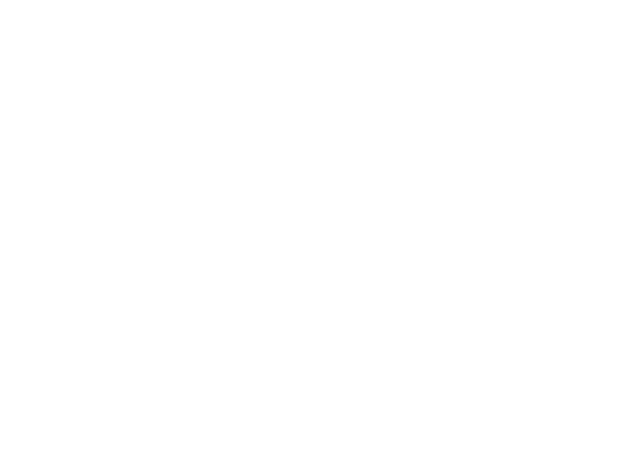

In [90]:
docs = chat_df.groupby("streamer_id")["chat"].apply(lambda x: " ".join(x))

vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords)
X = vectorizer.fit_transform(docs)

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
coords = tsne.fit_transform(X.toarray())

coords_df = pd.DataFrame(coords, columns=["x", "y"], index=docs.index)
coords_df["name"] = coords_df.index.map(id_to_name)

plt.axis("off")
plt.tight_layout()
plt.figure(figsize=(10,8))
plt.scatter(coords_df["x"], coords_df["y"])

for _, row in coords_df.iterrows():
    plt.text(row["x"]+0.05, row["y"]+0.05, row["name"], fontsize=9)

out_dir = "./similarity_map"
os.makedirs(out_dir, exist_ok=True)
plot_path = os.path.join(out_dir, "similarity_map.png")

plt.savefig(plot_path, dpi=150, bbox_inches="tight")
plt.close()